# Data Visualisation

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.colors as colors

In [4]:
movies_df = pd.read_csv('/Users/veronicabosso/PycharmProjects/csv/movie_df.csv')
release_df = pd.read_csv('/Users/veronicabosso/PycharmProjects/csv/releases.csv')
genres_df = pd.read_csv('/Users/veronicabosso/PycharmProjects/csv/genres.csv')
oscar_awards_df = pd.read_csv('/Users/veronicabosso/PycharmProjects/csv/oscar_awards_df.csv')
studios_df = pd.read_csv('/Users/veronicabosso/PycharmProjects/csv/studios_df.csv')

## Movies

### Number of films by decade


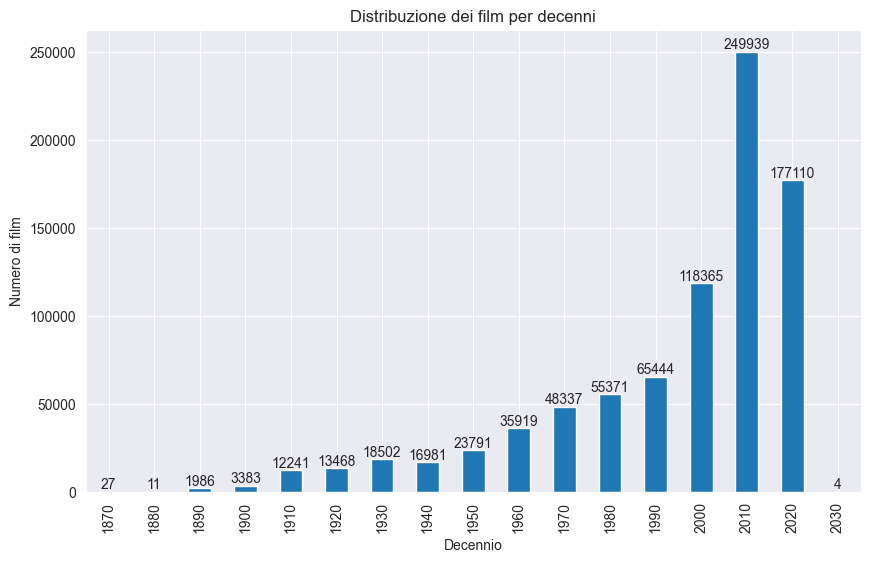

In [11]:
# Estrazione degli anni dalle date e creazione della colonna per i decenni
movies_df['Year'] = pd.to_datetime(movies_df['date']).dt.year
movies_df['Decade'] = (movies_df['Year'] // 10) * 10

# Contare il numero di film per decennio
decade_counts = movies_df['Decade'].value_counts().sort_index()

# Creazione del grafico a barre per decenni
plt.figure(figsize=(10, 6))
ax = decade_counts.plot(kind='bar')

# Modifica delle etichette dell'asse delle X
plt.xticks(ticks=range(len(decade_counts)), labels=[str(int(dec)) for dec in decade_counts.index])

# Aggiunta dei numeri sopra le barre
for i in ax.containers:
    ax.bar_label(i, label_type='edge')

plt.title('Distribuzione dei film per decenni')
plt.xlabel('Decennio')
plt.ylabel('Numero di film')
plt.show()

The histogram shows how the number of films grows from decade to decade.

We can see that in the 2010s the number has more than doubled compared to the 2000s, and that in the 2020s, even though we are halfway through the decade, we are on track to repeat the phenomenon.

### Number of films released

#### by country

In [59]:
release_df['Year'] = pd.to_datetime(release_df['date']).dt.year
country_counts = release_df['country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']

# Creazione della mappa geografica
fig = px.choropleth(country_counts, locations='Country', locationmode='country names',
                    color='Count', title='Numero di film rilasciati per paese')
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":40})
fig.show()

The map shows the number of film releases in total, not where these films are made.

However, it can be noted that many more films have been released in the United States than in the rest of the world, even other developed countries.

#### by country and year

In [60]:
# Caricamento dei dati con l'anno
release_df['Year'] = pd.to_datetime(release_df['date']).dt.year

# Contare il numero di film rilasciati per paese e per anno
country_year_counts = release_df.groupby(['country', 'Year']).size().reset_index(name='Count')

# Ordinare i dati per anno
country_year_counts = country_year_counts.sort_values(by='Year')

# Creazione della mappa geografica con animazione
fig = px.choropleth(country_year_counts, locations='country', locationmode='country names',
                    color='Count', title='Numero di film rilasciati per paese e anno',
                    animation_frame='Year', color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(margin={"r":0,"t":40,"l":0,"b":40})
fig.show()

Thanks to this map with time bar we notice that the first film was released in France, followed by the United States, England and Germany.

Note also that since 1903 the USA has always been the country with the highest number of releases.

### Comparison of film genres over the decades

In [38]:
# Unione dei dataset dei film e dei generi
merged_df = pd.merge(movies_df, genres_df, on='id')

# Estrazione dell'anno dalla colonna delle date
merged_df['Year'] = pd.to_datetime(merged_df['date']).dt.year

merged_df = merged_df[merged_df['Year'] < 2024]

# Raggruppamento dei dati per anno e genere, contando il numero di film
genre_counts_per_year = merged_df.groupby(['Year', 'genre']).size().reset_index(name='Count')

# Creazione del grafico a linee interattivo
fig = px.line(genre_counts_per_year, x='Year', y='Count', color='genre',
              title='Popolarità dei generi cinematografici nel tempo',
              markers=True)

# Mostrare il grafico
fig.show()

The interactive line graph created allows to compare all 19 film genres across the years.

In [58]:
# Filtrare solo gli anni dal 2000 al 2024
filtered_df = merged_df[(merged_df['Year'] >= 1980) & (merged_df['Year'] <= 2024)]

# Contare il numero di film per genere e anno
genre_trends = filtered_df.groupby(['Year', 'genre']).size().reset_index(name='Film Count')

# Prendere solo i primi 10 generi più popolari in totale
top_genres = genre_trends.groupby('genre')['Film Count'].sum().nlargest(10).index
genre_trends = genre_trends[genre_trends['genre'].isin(top_genres)]

# Creare il ranking per ogni anno
genre_trends['Rank'] = genre_trends.groupby('Year')['Film Count'].rank(method="min", ascending=False)

# Creare il Bump Chart con Plotly
fig = px.line(genre_trends, x='Year', y='Rank', color='genre', markers=True,
              title="Classifica dei generi cinematografici più popolari (2000-2024)")

# Invertire l'asse delle Y per far sì che il #1 sia in alto
fig.update_yaxes(autorange="reversed")

# Mostrare il grafico
fig.show()

The evolution of the most popular genre during the era of modern cinema (1980-2024) is shown in the bump chart.

## Oscar awards

### Actors and Actresses with the Most Oscars

In [22]:
# Filtrare solo i vincitori degli Oscar nelle categorie Actor e Actress
winners_df = oscar_awards_df[(oscar_awards_df['winner'] == True) & 
                             (oscar_awards_df['category'].isin(
                                 ['ACTOR', 'ACTRESS',
                                  'ACTOR IN A LEADING ROLE', 'ACTRESS IN A LEADING ROLE',
                                  'ACTOR IN A SUPPORTING ROLE', 'ACTRESS IN A SUPPORTING ROLE']))].copy()

# Aggiungere una colonna per il genere (Male o Female) utilizzando .loc
winners_df.loc[:, 'Gender'] = winners_df['category'].apply(
    lambda x: 'Male' if 'ACTOR' in x else 'Female'
)

# Raggruppare per attore, contare il numero di premi vinti e ottenere il genere
actor_oscar_counts = winners_df.groupby(['name', 'Gender']).size().reset_index(name='Oscar Wins')

# Filtrare gli attori che hanno vinto più di un premio Oscar
actor_oscar_counts = actor_oscar_counts[actor_oscar_counts['Oscar Wins'] > 1]

# Ordinare gli attori in base al numero di premi vinti (decrescente)
actor_oscar_counts = actor_oscar_counts.sort_values(by='Oscar Wins', ascending=False)

# Creazione del grafico a barre interattivo
fig = px.bar(actor_oscar_counts, x='name', y='Oscar Wins', color='Gender',
             title='Attori e Attrici con più premi Oscar',
             color_discrete_map={'Male': '#538bec', 'Female': '#FFC0CB'})  # Colori più delicati
# Personalizzare il grafico
fig.update_layout(xaxis_tickangle=-45, xaxis={'categoryorder': 'total descending'})

# Mostrare il grafico
fig.show()

The bar chart shows the actors and actresses who have won more than one Oscar.

In [29]:
# Attori nominati ali Oscar nelle categorie Actor e Actress
actors_nominated_df = oscar_awards_df[oscar_awards_df['category'].isin(
    ['ACTOR', 'ACTRESS',
     'ACTOR IN A LEADING ROLE', 'ACTRESS IN A LEADING ROLE',
     'ACTOR IN A SUPPORTING ROLE', 'ACTRESS IN A SUPPORTING ROLE'])].copy()

# Aggiungere una colonna per il genere (Male o Female) utilizzando .loc
actors_nominated_df.loc[:, 'Gender'] = actors_nominated_df['category'].apply(
    lambda x: 'Male' if 'ACTOR' in x else 'Female'
)

# Raggruppare per attore, contare il numero di premi vinti e ottenere il genere
actor_oscar_counts = actors_nominated_df.groupby(['name', 'Gender']).size().reset_index(name='Oscar Wins')

# Filtrare gli attori che hanno vinto più di un premio Oscar
actor_oscar_counts = actor_oscar_counts[actor_oscar_counts['Oscar Wins'] > 5]

# Ordinare gli attori in base al numero di premi vinti (decrescente)
actor_oscar_counts = actor_oscar_counts.sort_values(by='Oscar Wins', ascending=False)

# Creazione del grafico a barre interattivo
fig = px.bar(actor_oscar_counts, x='name', y='Oscar Wins', color='Gender',
             title='Attori e Attrici con più premi Oscar',
             color_discrete_map={'Male': '#538bec', 'Female': '#FFC0CB'})  # Colori più delicati
# Personalizzare il grafico
fig.update_layout(xaxis_tickangle=-45, xaxis={'categoryorder': 'total descending'})

# Mostrare il grafico
fig.show()

The bar chart shows the actors and actresses who have been nominated for more than five Oscars.

### Film with the Most Oscars

In [19]:
# Filtrare solo i vincitori degli Oscar
winners_df = oscar_awards_df[oscar_awards_df['winner'] == True]

# Raggruppare per film e contare il numero di premi vinti
film_oscar_counts = winners_df.groupby(['film', 'year_film']).size().reset_index(name='Oscar Wins')

# Filtrare i film che hanno vinto più di 5 premi Oscar
film_oscar_counts = film_oscar_counts[film_oscar_counts['Oscar Wins'] > 5]

# Ordinare i film in base al numero di premi vinti (decrescente)
film_oscar_counts = film_oscar_counts.sort_values(by='Oscar Wins', ascending=False)

# Creazione del grafico a barre interattivo
fig = px.bar(film_oscar_counts, x='film', y='Oscar Wins',
             title='Film con più premi Oscar',
             text='Oscar Wins')  # Mostra il numero di premi sopra le barre

# Personalizzare il grafico
fig.update_layout(xaxis_tickangle=-45)

# Mostrare il grafico
fig.show()

The bar chart shows the films that have won more than five Oscars.

In [18]:
# Raggruppare per film e anno, contando le nomination
film_nomination_counts = oscar_awards_df.groupby(['film', 'year_film']).size().reset_index(name='Oscar Nominations')

# Filtrare i film che hanno ricevuto più di 10 nomination
film_nomination_counts = film_nomination_counts[film_nomination_counts['Oscar Nominations'] > 11]

# Creazione del grafico a barre interattivo
fig = px.bar(film_nomination_counts, x='film', y='Oscar Nominations',
    title='Film con più nomination agli Oscar',
    text='Oscar Nominations',  # Mostra il numero di nomination sopra le barre
    color_continuous_scale='Blues'  # Gradiente di colore per evidenziare i più nominati
)

# Personalizzare il grafico
fig.update_layout(
    xaxis_tickangle=-45, 
    xaxis={'categoryorder': 'total descending'},  # Ordina per numero di nomination
)

# Mostrare il grafico
fig.show()

The bar chart shows the films that have received more than 11 Oscar nominations.

## Genres

In [98]:
# Unire i dataset dei film e degli studios usando la colonna 'id'
merged_df = pd.merge(movies_df, studios_df, on='id')

# Raggruppare per studio e contare il numero totale di film prodotti
studios_film_counts = merged_df.groupby('studio').size().reset_index(name='Film Count')
studios_film_counts = pd.merge(studios_film_counts, total_film_counts, on='studio')
studios_film_counts = studios_film_counts[studios_film_counts['Total Film Count'] > 1000]

# Creazione del grafico a dispersione interattivo
fig = px.scatter(studios_film_counts, x='Film Count', y='Film Count', 
                 title='Produzione Totale dei Film per Studio', log_x=True,
                 size='Film Count', color='Film Count', hover_name='studio')

# Mostrare il grafico
fig.show()